# Sentinel 2 Waterbodies <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers)

## Background

[DEA Waterbodies](https://www.ga.gov.au/dea/products/dea-waterbodies) is a time-series data product that summarises the surface area of open waterbodies in Australia using [Water Observations from Space (WOfS)](https://www.ga.gov.au/dea/products/wofs). WOfS classifies Landsat pixels into wet and dry. Landsat data have a resolution of 25m$^2$, but it would be really nice if we could instead use Sentinel 2 data with its 10m$^2$ resolution. This would help distinguish neighbouring waterbodies that are blurred together in Landsat (and hence in DEA Waterbodies). Sentinel 2 does not yet have WOfS.

One alternative to WOfS that we _could_ evaluate for Sentinel 2 is the [modified normalised difference water index (MNDWI)](http://doi.org/10.1080/01431160600589179), which can be calculated directly from surface reflectance. MNDWI greater than zero is indicative of water. It is not as accurate as WOfS, but easier to obtain.

## Description
This notebook compares DEA Waterbodies derived from WOfS to an analogous product derived from MNDWI. There are two main factors we can vary: how to derive our polygons, and how to derive our time series. Both polygons and time series can be generated from Landsat WOfS, from Landsat MNDWI, or from Sentinel 2 MNDWI. We can choose to combine any polygon method and any time series method. This gives us a grid of possible evaluations:

| | Landsat WOfS polygons | Landsat MNDWI polygons | Sentinel 2 MNDWI polygons |
|-|---------------|------------------------|---------------------------|
|**Landsat WOfS time series** | DEA Waterbodies | Polygon proxy quality | Good differentation for merged waterbodies |
|**Landsat MNDWI time series** | Time series proxy quality | Total proxy quality | - |
|**Sentinel 2 MNDWI time series** | Sentinel 2 proxy quality | - | Highest resolution |

The upper corner is simply the existing DEA Waterbodies. Polygons derived from Sentinel 2 would be great for differentiating neighbouring waterbodies, even with lower resolution surface area data. Landsat WOfS polygons with MNDWI time series informs us how well MNDWI approximates the surface area time series. Similarly, Landsat MNDWI polygons with WOfS time series informs us how well the MNDWI polygons approximate those we obtain from WOfS. The highest attainable resolution is deriving both parts of the product from Sentinel 2.

***

## Getting started

Edit the analysis parameters and run all the cells in this notebook to analyse a region of Australia.

### Load packages
Import Python packages that are used for the analysis.

In [383]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import datacube.virtual as virtual
import geopandas as gpd
from tqdm.notebook import tqdm
import matplotlib.cm

sys.path.append("../Scripts")
from dea_plotting import display_map
from dea_spatialtools import xr_rasterize, xr_vectorize

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [109]:
dc = datacube.Datacube(app="Sentinel_2_Waterbodies")

### Analysis parameters

Choose which area of Australia to analyse:

In [382]:
# Lake Boort and Lake Lyndger
xlim = (143.70141, 143.76180)
ylim = (-36.14517, -36.09688)

### Check the analysis area

Display a map of the area we plan to analyse.

In [110]:
display_map(x=xlim, y=ylim)

## Build a virtual product for the MNDWI calculation

The MNDWI (DOI:10.1080/01431160600589179) is given by

$$
    \frac{\mathrm{green} - \mathrm{SWIR}}{\mathrm{green} + \mathrm{SWIR}}.
$$

We'll build a virtual product that calculates this without having to load all of the channels ourselves. A virtual product is just like a regular DEA product, except it has some transformations applied before we see it. We can define one with YAML that applies cloud masking and calculates the MNDWI:

In [111]:
cat_yaml = """
products:
    ls8_MNDWI:
        recipe:
            transform: expressions
            output:
                MNDWI:
                    formula: (green - swir1) / (green + swir1)
                    dtype: float32
            input:
                transform: apply_mask
                mask_measurement_name: fmask
                input:
                    transform: expressions
                    output:
                        fmask: 
                            formula: (fmask == 1) | (fmask == 5)
                            nodata: False
                        green: green
                        swir1: swir1
                    input:
                          product: ga_ls8c_ard_3
                          measurements: [green, swir1, fmask]
                          output_crs: EPSG:3577
                          resolution: [-30, 30]
                          resampling:
                              fmask: nearest
                              '*': average
    s2a_MNDWI:
        recipe:
            transform: expressions
            output:
                MNDWI:
                    formula: (nbart_green - nbart_swir_2) / (nbart_green + nbart_swir_2)
                    dtype: float32
            input:
                transform: apply_mask
                mask_measurement_name: fmask
                input:
                    transform: expressions
                    output:
                        fmask: 
                            formula: (fmask == 1) | (fmask == 5)
                            nodata: False
                        nbart_green: nbart_green
                        nbart_swir_2: nbart_swir_2
                    input:
                        collate:
                            - product: s2b_ard_granule
                              measurements: [nbart_green, nbart_swir_2, fmask]
                              output_crs: EPSG:3577
                              resolution: [-10, 10]
                              resampling:
                                  fmask: nearest
                                  '*': average
                            - product: s2a_ard_granule
                              measurements: [nbart_green, nbart_swir_2, fmask]
                              output_crs: EPSG:3577
                              resolution: [-10, 10]
                              resampling:
                                  fmask: nearest
                                  '*': average
    wofs_masked:
        recipe:
            transform: expressions
            output:
                water:
                    formula: water
                    nodata: -1
            input:
                transform: apply_mask
                mask_measurement_name: mask
                input:
                    transform: expressions
                    output:
                        mask: 
                            formula: (water == 0) | (water == 128)
                            nodata: False
                        water:
                            formula: water
                            nodata: -1
                    input:
                        product: wofs_albers
                        measurements: [water]
                        output_crs: EPSG:3577
                        resolution: [-25, 25]
"""

Then we can convert the YAML into a catalogue, which we can use just like a datacube:

In [112]:
cat = virtual.catalog_from_yaml(cat_yaml)

Now we can use this catalogue to load our MNDWI virtual products for Sentinel 2 and Landsat 8. Use dask to avoid loading everything into memory at once.

In [116]:
dask_chunks = {"x": 300, "y": 300, "time": 1}
s2a_mndwi = cat["s2a_MNDWI"].load(
    dc,
    x=xlim,
    y=ylim,
    time=("2015-11", "2020-09"),
    group_by="solar_day",
    dask_chunks=dask_chunks,
)
ls8_mndwi = cat["ls8_MNDWI"].load(
    dc,
    x=xlim,
    y=ylim,
    time=("2015-11", "2020-09"),
    group_by="solar_day",
    dask_chunks=dask_chunks,
)

Finally, grab WOfS for the same time period as our Landsat observations. WOfS is calculated based on Landsat, so it should have data for the exact same times as Landsat does.

In [117]:
times = [str(t.values) for t in ls8_mndwi.time]

wofs = cat["wofs_masked"].load(
    dc, x=xlim, y=ylim, time=times, dask_chunks=dask_chunks
)  # Matches LS8 time
wofs = xr.where(wofs == 128, 1, xr.where(wofs == 0, 0, np.nan))

## Calculate an all-time average

In analogy to WOfS all-time summary, calculate an all-time average for water derived from MNDWI. First, let's threshold each MNDWI frame so we can find the water. What would be a good threshold? This may vary depending on the satellite.

In [126]:
# Find all the dates common to both datasets so we can visualise them with a fair comparison.
common_dates = sorted(
    set(list(s2a_mndwi.time.astype("datetime64[D]").values))
    & set(list(ls8_mndwi.time.astype("datetime64[D]").values))
)

Text(0.5, 1.0, 'LS8 > threshold')

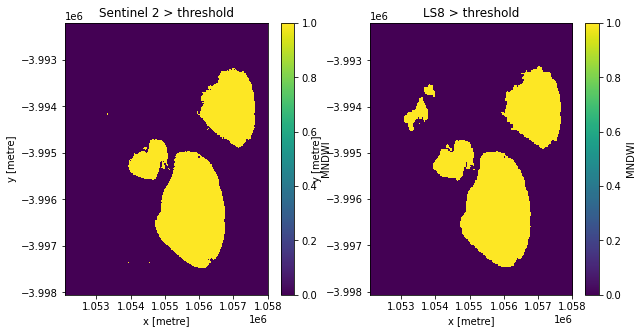

In [133]:
s2_threshold = 0
ls8_threshold = 0

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
(
    s2a_mndwi.MNDWI.sel(time=common_dates[3], method="nearest") > s2_threshold
).plot.imshow(ax=axs[0])
(
    ls8_mndwi.MNDWI.sel(time=common_dates[3], method="nearest") > ls8_threshold
).plot.imshow(ax=axs[1])
axs[0].set_title("Sentinel 2 > threshold")
axs[1].set_title("LS8 > threshold")

A variable threshold like local Otsu thresholding might be useful in future.

Next, summarise these thresholded scenes and also generate a summary for WOfS by calculating how often each pixel is wet in the data.

Here we make the summaries and plot them. I've chosen some thresholds for S2 and LS8 that seem to get the best results and plotted these as contours - in reality we'd have no manual oversight on this, so this is something of a best-case attempt. To match the methodology of DEA Waterbodies, we need two thresholds: one for identifying waterbodies and one for finding their maximum extent. In WOfS (DEA Waterbodies) these are 5% and 10% respectively.

In [134]:
s2a_mndwi_summary = (s2a_mndwi >= s2_threshold).MNDWI.mean(axis=0).load()

In [135]:
ls8_mndwi_summary = (ls8_mndwi >= ls8_threshold).MNDWI.mean(axis=0).load()

In [136]:
wofs_summary = wofs.water.mean(axis=0).load()

In [147]:
s2a_thresholds = [0.03, 0.08]
ls8_thresholds = [0.05, 0.10]
wofs_thresholds = [0.05, 0.10]

Text(0.5, 1.0, 'WOfS water frequency')

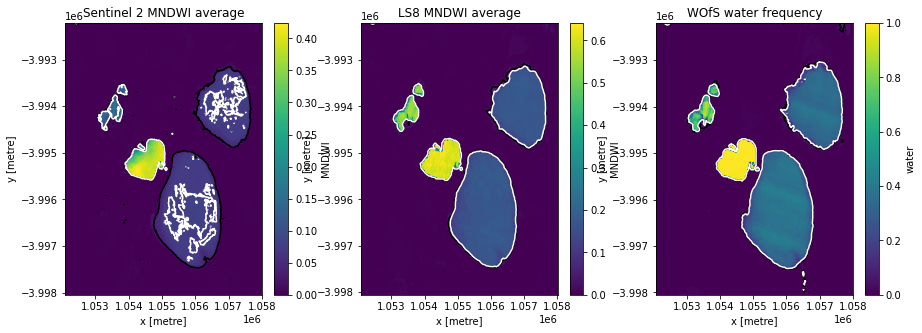

In [148]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
colours = ["black", "white"]
s2a_mndwi_summary.plot.imshow(ax=axs[0])
ls8_mndwi_summary.plot.imshow(ax=axs[1])
s2a_mndwi_summary.plot.contour(levels=s2a_thresholds, ax=axs[0], colors=colours)
ls8_mndwi_summary.plot.contour(levels=ls8_thresholds, ax=axs[1], colors=colours)
wofs_summary.plot.contour(levels=wofs_thresholds, ax=axs[2], colors=colours)
wofs_summary.plot.imshow(ax=axs[2])
axs[0].set_title("Sentinel 2 MNDWI average")
axs[1].set_title("LS8 MNDWI average")
axs[2].set_title("WOfS water frequency")

## Generating polygons

We can generate polygons by judicious choice of threshold for each of these. TODO: Use an adaptive threshold.

The existing method for DEA Waterbodies is to generate polygons at the 10% level as well as the 5% level. Then, use the 10% polygons to detect waterbodies and the 5% waterbodies to get the maximum extent. We will use the thresholds from above, which are different for Sentinel 2 and Landsat.

In [395]:
def mask_to_polygons(mask):
    gdf = xr_vectorize(mask, crs="EPSG:3577")
    # Vectorised polygons will have their attribute column
    # set based on the pixel values of the mask.
    # This is a boolean mask, so we can just check
    # for attribute == 1.
    return gdf[gdf.attribute == 1]

In [398]:
s2a_lower_wbs = mask_to_polygons(s2a_mndwi_summary >= s2a_thresholds[0])
s2a_upper_wbs = mask_to_polygons(s2a_mndwi_summary >= s2a_thresholds[1])

In [399]:
ls8_lower_wbs = mask_to_polygons(ls8_mndwi_summary >= ls8_thresholds[0])
ls8_upper_wbs = mask_to_polygons(ls8_mndwi_summary >= ls8_thresholds[1])

In [400]:
wofs_lower_wbs = mask_to_polygons(wofs_summary >= wofs_thresholds[0])
wofs_upper_wbs = mask_to_polygons(wofs_summary >= wofs_thresholds[1])

Use the lower boundaries, but only if they contain an upper polygon.

In [401]:
s2a_wbs = s2a_lower_wbs.loc[
    gpd.sjoin(s2a_lower_wbs, s2a_upper_wbs, how="right").index_left
]
ls8_wbs = ls8_lower_wbs.loc[
    gpd.sjoin(ls8_lower_wbs, ls8_upper_wbs, how="right").index_left
]
wofs_wbs = wofs_lower_wbs.loc[
    gpd.sjoin(wofs_lower_wbs, wofs_upper_wbs, how="right").index_left
]

Let's discard everything less than 5 Landsat pixels in area: 4500 m$^2$ for Landsat Collection 3. This matches the methodology of DEA Waterbodies.

In [402]:
area_threshold = 4500

In [403]:
s2a_wbs = s2a_wbs[s2a_wbs.area >= area_threshold]
ls8_wbs = ls8_wbs[ls8_wbs.area >= area_threshold]
wofs_wbs = wofs_wbs[wofs_wbs.area >= area_threshold]

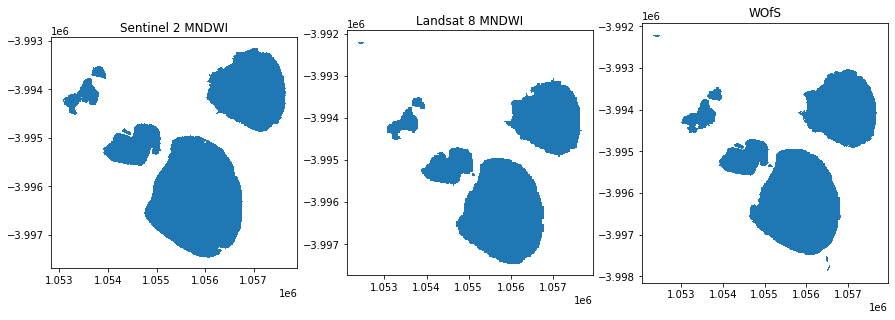

In [404]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for wbs, ax, t in zip(
    [s2a_wbs, ls8_wbs, wofs_wbs], axs, ["Sentinel 2 MNDWI", "Landsat 8 MNDWI", "WOfS"]
):
    wbs.plot(ax=ax)
    ax.set_title(t)

We end up with a few polygons that are duplicated or overlapping. Combine these by doing a unary union and then split back into polygons again.

In [219]:
s2a_wbs = gpd.GeoDataFrame(
    geometry=[poly for poly in s2a_wbs.unary_union], crs="EPSG:3577"
)
ls8_wbs = gpd.GeoDataFrame(
    geometry=[poly for poly in ls8_wbs.unary_union], crs="EPSG:3577"
)
wofs_wbs = gpd.GeoDataFrame(
    geometry=[poly for poly in wofs_wbs.unary_union], crs="EPSG:3577"
)

Finally give everything a new ID. We can use this later to generate our masks.

In [220]:
s2a_wbs["ID"] = np.arange(1, len(s2a_wbs) + 1).astype(int)
ls8_wbs["ID"] = np.arange(1, len(ls8_wbs) + 1).astype(int)
wofs_wbs["ID"] = np.arange(1, len(wofs_wbs) + 1).astype(int)

Set the ID to be the index so we can query by it. Don't drop the ID so we can use it as a column for later rasterising.

In [221]:
s2a_wbs.set_index("ID", drop=False, inplace=True)
ls8_wbs.set_index("ID", drop=False, inplace=True)
wofs_wbs.set_index("ID", drop=False, inplace=True)

## Surface area time series comparison

Let's choose a waterbody and compare time series derived from different methods.

Select a polygon in the Sentinel 2 waterbodies:

In [222]:
s2a_wb = s2a_wbs.iloc[0]

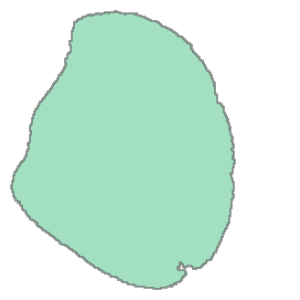

In [223]:
s2a_wb.geometry

Then find its equivalent in Landsat MNDWI and WOfS polygons by finding the polygon with the largest intersection.

In [224]:
ls8_wb = ls8_wbs.iloc[ls8_wbs.intersection(s2a_wb.geometry).area.argmax()]
wofs_wb = wofs_wbs.iloc[wofs_wbs.intersection(s2a_wb.geometry).area.argmax()]

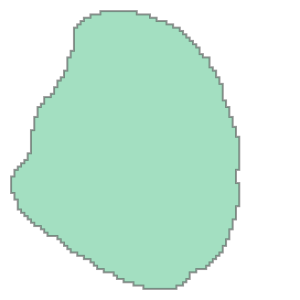

In [225]:
ls8_wb.geometry

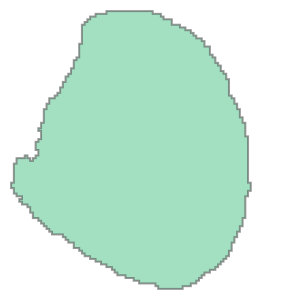

In [226]:
wofs_wb.geometry

Calculate a mask that matches the waterbodies. There are nine masks, which corresponds to three different polygon sets and three different time series.

In [247]:
polygon_sets = {
    "wofs": wofs_wbs,
    "ls8": ls8_wbs,
    "s2a": s2a_wbs,
}

ts_dataarrays = {
    "wofs": wofs.water,
    "ls8": ls8_mndwi.MNDWI >= ls8_threshold,
    "s2a": s2a_mndwi.MNDWI >= s2_threshold,
}

ids = {
    "wofs": wofs_wb.ID,
    "ls8": ls8_wb.ID,
    "s2a": s2a_wb.ID,
}

area_per_px = {
    "wofs": 25 ** 2,
    "ls8": 30 ** 2,
    "s2a": 10 ** 2,
}

In [244]:
masks = {}  # (polygons, time series)
for poly_name, poly_set in polygon_sets.items():
    for ts_name, ts_dataarray in ts_dataarrays.items():
        mask = xr_rasterize(poly_set, ts_dataarray.isel(time=0), attribute_col="ID")
        masks[poly_name, ts_name] = mask

Rasterizing to match xarray.DataArray dimensions (234, 237)
Rasterizing to match xarray.DataArray dimensions (196, 198)
Rasterizing to match xarray.DataArray dimensions (584, 592)
Rasterizing to match xarray.DataArray dimensions (234, 237)
Rasterizing to match xarray.DataArray dimensions (196, 198)
Rasterizing to match xarray.DataArray dimensions (584, 592)
Rasterizing to match xarray.DataArray dimensions (234, 237)
Rasterizing to match xarray.DataArray dimensions (196, 198)
Rasterizing to match xarray.DataArray dimensions (584, 592)


Each mask has pixels set to the ID value of the polygon that contains those pixels.

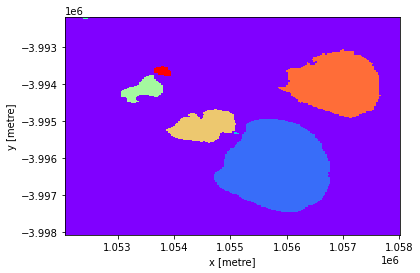

In [381]:
masks["ls8", "ls8"].plot(cmap="rainbow", add_colorbar=False)

Use the masks to extract pixel values for each time. We also want to extract how many pixels are invalid, so we can figure out which days have good observations.

In [248]:
ts_wet = {}
ts_invalid = {}
for ts_name, ts_dataarray in ts_dataarrays.items():
    for poly_name, poly_set in polygon_sets.items():
        mask = masks[poly_name, ts_name] == ids[poly_name]
        ts_wet[poly_name, ts_name] = (
            ts_dataarray.where(mask).sum(axis=(1, 2)) * area_per_px[ts_name]
        )
        ts_invalid[poly_name, ts_name] = (
            ts_dataarray.isnull().where(mask).sum(axis=(1, 2)) * area_per_px[ts_name]
        )

DEA Waterbodies considers an observation valid if there is at least 90% valid pixels.

In [254]:
ts_ok = {}
for (poly_name, ts_name), invalid_px in ts_invalid.items():
    max_extent = polygon_sets[poly_name].area.loc[ids[poly_name]]
    ts_ok[poly_name, ts_name] = ts_invalid[poly_name, ts_name] < 0.1 * max_extent

We can plot all of these time series now.

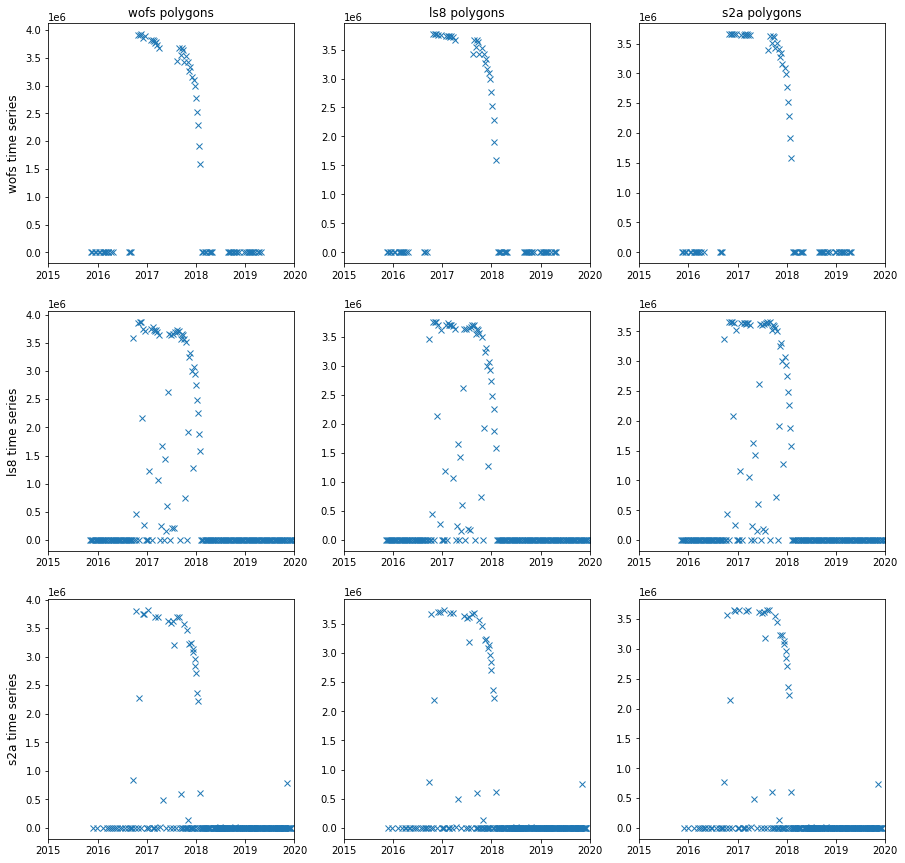

In [310]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
# Subplot label padding.
padding = 10  # pt
# Our datasets have different date ranges, so set these manually for display.
wofs_xlimits = (wofs.time.values.min(), wofs.time.values.max())
xticks = np.arange(np.datetime64("2015", "Y"), np.datetime64("2021", "Y"))
for x, poly_name in enumerate(polygon_sets):
    for y, ts_name in enumerate(ts_dataarrays):
        ax = axs[y, x]

        # https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
        if x == 0:
            # Label the vertical axis of subplots.
            ax.annotate(
                s=ts_name + " time series",
                xy=(-0.1, 0.5),
                xycoords="axes fraction",
                textcoords="offset points",
                size="large",
                ha="center",
                va="center",
                xytext=(-padding, 0),
                rotation="vertical",
            )
        if y == 0:
            # Label the horizontal axis of subplots.
            ax.annotate(
                s=poly_name + " polygons",
                xy=(0.5, 1),
                xycoords="axes fraction",
                textcoords="offset points",
                size="large",
                ha="center",
                va="center",
                xytext=(0, padding),
                rotation="horizontal",
            )

        # Plot valid dates of the time series.
        ok = ts_ok[poly_name, ts_name]
        ts = ts_wet[poly_name, ts_name]
        ax.plot(ts.time[ok], ts[ok], marker="x", linestyle="None")

        ax.set_xlim(wofs_xlimits)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)

The MNDWI series are noticably noisier, with lots of no-water or low-water observations that are wet in WOfS. However, the general pattern matches WOfS, and in particular seems to bound it below. Maybe we could consider MNDWI a lower bound for wetness?

We can also estimate a mean-squared difference between each time series and the WOfS time series with WOfS polygons (= DEA Waterbodies). This assumes Gaussian error, but for sufficiently large numbers of pixels the binomial distribution we actually have should be well-approximated by a Gaussian. By calculating such a difference, we can summarise the discrepancies between the above plots as a single number per plot.

In [331]:
# Make a pandas series of valid data for comparison.
# We resample to daily to avoid time rounding issues.
ok = ts_ok["wofs", "wofs"]
ts = ts_wet["wofs", "wofs"]
comparison_series = (
    pd.Series(ts[ok], index=ts.time[ok].values, name="comparison").resample("D").mean()
)

differences = {}
for poly_name in polygon_sets:
    for ts_name in ts_dataarrays:
        # Make a pandas series of valid data.
        ok = ts_ok[poly_name, ts_name]
        ts = ts_wet[poly_name, ts_name]
        series = (
            pd.Series(ts[ok], index=ts.time[ok].values, name="test")
            .resample("D")
            .mean()
        )
        # Join this with the comparison series to have a unified time index.
        joint_series = pd.merge(
            series, comparison_series, left_index=True, right_index=True, how="outer"
        )
        # Interpolate and compute the difference.
        joint_series.interpolate(inplace=True)
        difference = joint_series.test - joint_series.comparison
        # The mean-squared error is the difference we seek.
        differences[poly_name, ts_name] = (difference ** 2).mean()

Now we can look at these differences as a table.

In [342]:
differences

{('wofs', 'wofs'): 0.0,
 ('wofs', 'ls8'): 971367393409.1212,
 ('wofs', 's2a'): 1725083956623.2422,
 ('ls8', 'wofs'): 1694839621.214598,
 ('ls8', 'ls8'): 976307276248.1262,
 ('ls8', 's2a'): 1732007278279.1943,
 ('s2a', 'wofs'): 5886091941.865738,
 ('s2a', 'ls8'): 988149145830.5065,
 ('s2a', 's2a'): 1739415853685.8083}

([<matplotlib.axis.YTick at 0x7f9b865792b0>,
 [Text(0, 0, 'ls8 time series'),
  Text(0, 0, 's2a time series'),
  Text(0, 0, 'wofs time series')])

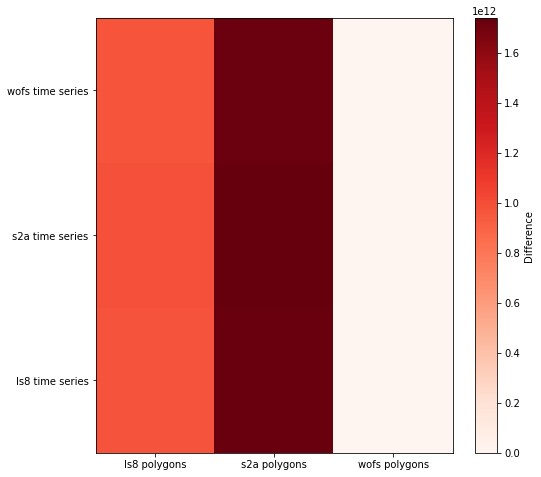

In [377]:
fig = plt.figure(figsize=(8, 8))
grid = np.zeros((3, 3))
for x, poly_name in enumerate(sorted(polygon_sets)):
    for y, ts_name in enumerate(sorted(ts_dataarrays)):
        grid[x, y] = differences[poly_name, ts_name]
plt.pcolor(grid, cmap="Reds")
plt.colorbar(label="Difference")
plt.xticks(np.arange(3) + 0.5, [i + " polygons" for i in sorted(polygon_sets)])
plt.yticks(np.arange(3) + 0.5, [i + " time series" for i in sorted(ts_dataarrays)])

The polygons dominate the differences between the time series. This shows that the polygons are the most important change here between the datasets, dwarfing the impact of the low-water observations. To see these more clearly, we can normalise the difference by the kind of polygons before we plot:

([<matplotlib.axis.YTick at 0x7f9b86332668>,
 [Text(0, 0, 'ls8 time series'),
  Text(0, 0, 's2a time series'),
  Text(0, 0, 'wofs time series')])

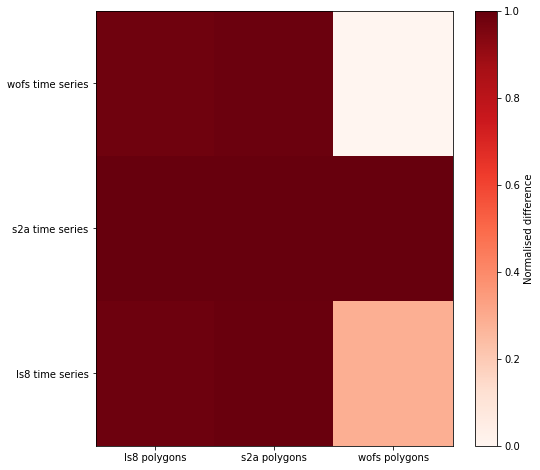

In [380]:
fig = plt.figure(figsize=(8, 8))
plt.pcolor(grid / grid.max(axis=0), cmap="Reds")
plt.colorbar(label="Normalised difference")
plt.xticks(np.arange(3) + 0.5, [i + " polygons" for i in sorted(polygon_sets)])
plt.yticks(np.arange(3) + 0.5, [i + " time series" for i in sorted(ts_dataarrays)])

S2 and LS8 MNDWI are equally good when applied to non-WOfS polygons. S2 time series deviate appreciably when applied to WOfS polygons, though. This makes sense because S2 will include lots of dry areas considered part of the waterbody by the much larger WOfS pixels.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020

**Compatible datacube version:** 

In [77]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)